<a href="https://colab.research.google.com/github/Billwuzl/Domain-Adaptation/blob/main/Fineture_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [ ]:
import sys
sys.executable

'/usr/bin/python3'

In [ ]:
import pickle

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline    
# pics in html, helps with plots
from matplotlib.pyplot import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 7, 7  # figure default params, dictionary - should add here!

In [ ]:
import re
from collections import Counter

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import ParameterSampler

In [ ]:
from scipy.stats.distributions import uniform

## Functions

In [ ]:
# 11NOV
# function for cleaning the raw IMDB strings, takes 36sec
# would we need a token for sentence start/end, such as <ss>?

REPL_NO_SPACE = re.compile("(\t)|(\n)|(\*)|(\`)|(\´)|(\.)|(\~)|(\;)|(\:)|(\!)|(\&)|(\$)|\
                           (\*)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPL_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|(\=)|(\+)")

def preprocess_reviews(reviews):    
    reviews = [REPL_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPL_WITH_SPACE.sub(" ", line) for line in reviews]
    reviews = [re.compile("(\s*\d+\s*)").sub(" ntkn ", line) for line in reviews] 
    reviews = [re.compile("\s\s+").sub(" ", line) for line in reviews]   
    reviews = [re.sub(r'\b(\w+)( \1\b)+', r'\1', line) for line in reviews] # duplicate consecutive words
    reviews = [line.rstrip() for line in reviews]
    return reviews

In [ ]:
# 11nov
# check the lengths in the dataset

def lengths_illustrator(texts):
    lengths = [len(k.split()) for k in texts]
    print("")
    print("corpus size, min length, max length:")
    print((len(lengths), min(lengths), max(lengths)))
    print("mean length:")
    print(round(sum(lengths)/len(lengths)))
    print("min tail:")
    print(sorted(lengths, reverse=False)[:10])
    print("max tail:")
    print(sorted(lengths, reverse=True)[:10])
    print("")

    a = np.array(lengths) 
    plt.hist(a, bins = 100)   
    plt.title("Histogram of text lengths\n", fontsize = 25) 
    plt.grid(True)
    plt.xlim([0.0, 1100.0])
    plt.xticks(range(0, 1100, 100))
    plt.tick_params(labelsize=12)
    plt.show()
    
    return lengths

In [ ]:
# 11 NOV
# remove data entries of length below minlength and above maxlength 
# shuffle
# would only do shuffling, if minlength and maxlength not input

def length_adjust(texts, labels, minlength = 1, maxlength=10000):

    lengths = [len(k.split()) for k in texts]
    indeces = []
        
    for i in range(len(lengths)):    
        if lengths[i] >= minlength and lengths[i] <= maxlength:                                  
            indeces.append(i)

    output = []
    l_output = []
    for index in indeces:
        output.append(texts[index])
        l_output.append(labels[index])
        
    output_np = np.asarray(output)   
    labels_np = np.asarray(l_output)
    indices = np.arange(output_np.shape[0])
    np.random.shuffle(indices)
    output_np = output_np[indices]
    labels_np = labels_np[indices]
    
    return output_np.tolist(), labels_np.tolist()

In [ ]:
# 7NOV
# returns sorted lists of n-grams and their popularity in the dataset

def ngrams(inp, length = 1000, nrange = (2, 6)):
    cv = CountVectorizer(ngram_range=nrange, binary=False, max_features = length, 
                         token_pattern= r'\b\w+\b')
    X = cv.fit_transform(inp)
    tokens = cv.get_feature_names()
    counts = np.asarray(X.sum(axis=0)).ravel()                
    
    tokens, counts = (list(t) for t in zip(*sorted(zip(tokens, counts), key=lambda x: x[1], reverse = True)))
    
    return tokens, counts

In [ ]:
def replace(texts, strings, ch = ' '):
    # 16MAR21
    # this assumes good text cleaning

    texts2 = []
    r = sorted(strings, key=lambda x: len(x.split()), reverse=True)
    
    for ad in texts:
        for remstring in r:
            remstring = " "+remstring+" "
            ad = ad.replace(remstring, ch)
        texts2.append(ad)

    return texts2

In [ ]:
# 7NOV
# returns sorted lists of words and their popularity in the dataset
# takes a list of strings

def wordcounter(inp):
        
    all_words = []
    
    for i in range(len(inp)):
        all_words.extend(inp[i].split())
    c = Counter(all_words)
    
    tokens = []
    counts = []

    for t in set(all_words):
        tokens.append(t)
        counts.append(c[t])
    
    tokens, counts = (list(t) for t in zip(*sorted(zip(tokens, counts), key=lambda x: x[1], reverse = True)))
    
    return tokens, counts

In [ ]:
# 12nov
# this takes "counts" as a global variable and plots individual word frequencies
# illustration of the Zipf's law

def fplotter():
    plt.plot(range(len(counts)), counts)
    plt.grid(True)
    plt.title("Frequency of individual words \n", fontsize = 25)
    plt.ylabel("Frequency in corpus", fontsize = 15)
    plt.xlabel("Ranked words", fontsize = 15)
    plt.tick_params(labelsize=20)
    plt.show()
    plt.plot(range(len(counts[:500])), counts[:500])
    plt.grid(True)
    plt.title("Frequency of individual words, top x popular words \n", fontsize = 25)
    plt.ylabel("Frequency in corpus", fontsize = 15)
    plt.xlabel("Ranked words", fontsize = 15)
    plt.tick_params(labelsize=20)
    plt.show()

In [ ]:
# 12nov
# a tool to simplify vocabulary
# keep only the npop most popular words in a corpus (including one token for "unknown")
# this takes a list of word tokens, ordered by popularity
# doing this could save us computing power on e.g. Keras tokenizer or count vectoriser

def pruner(X, npop, tkns):
    texts = [a.split() for a in X]
    keeplist = tkns[:npop-1]    
    for i in range(len(texts)):        
        for j in range(len(texts[i])):
            if texts[i][j] not in keeplist:
                texts[i][j] = 'unkn###'       # the "unknown" token   
    separator = ' '
    output = []
    for i in range(len(texts)):
        output.append(separator.join(texts[i]))
    return output

## Load the raw data, investigate, clean
## We stay with the training data set for now, leave out the test set

In [ ]:
with open("/content/texts_unsup.txt", "rb") as xx:
    texts = pickle.load(xx)

texts = preprocess_reviews(texts)

df = []
for i in range(len(texts)):
  df.append(texts[i])

import pandas as pd

df = pd.DataFrame(df,columns = ['text'])

len(texts)


50000

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!pip install transformers
!pip install datasets

# import needed lib
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import json
import torch

from datasets import Dataset, DatasetDict
from datasets import load_metric

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score,f1_score


import transformers
from transformers import AutoModel, BertTokenizer, BertForPreTraining
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)
from transformers import Trainer,TrainingArguments

import glob
import random
import datetime
import dask.dataframe as dd



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_train, df_unsup = train_test_split(df, shuffle=True,test_size=0.2)

# df_train = df_train.sample(n=10000,random_state=1)
ds= DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=20, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)

ds_mlm = ds_mlm.remove_columns(["text"])

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-IMDB_distilbert", 
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["train"], eval_dataset=ds_mlm["unsup"])

trainer.train()

Cloning https://huggingface.co/Billwzl/distilbert-base-uncased-IMDB_distilbert into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss
1,3.153100,2.954454
2,2.925100,2.857719
3,2.786500,2.845951
4,2.692000,2.776895
5,2.611000,2.837348
6,2.534100,2.710475
7,2.488700,2.686373
8,2.429200,2.659975
9,2.352400,2.687184
10,2.321700,2.652696


TrainOutput(global_step=20000, training_loss=2.4740373901367185, metrics={'train_runtime': 1044.8252, 'train_samples_per_second': 612.543, 'train_steps_per_second': 19.142, 'total_flos': 3314028902400000.0, 'train_loss': 2.4740373901367185, 'epoch': 16.0})

Upload file pytorch_model.bin:   0%|          | 3.34k/256M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Billwzl/distilbert-base-uncased-IMDB_distilbert
   01b7457..3497133  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Billwzl/distilbert-base-uncased-IMDB_distilbert
   01b7457..3497133  main -> main

To https://huggingface.co/Billwzl/distilbert-base-uncased-IMDB_distilbert
   3497133..881e674  main -> main

   3497133..881e674  main -> main



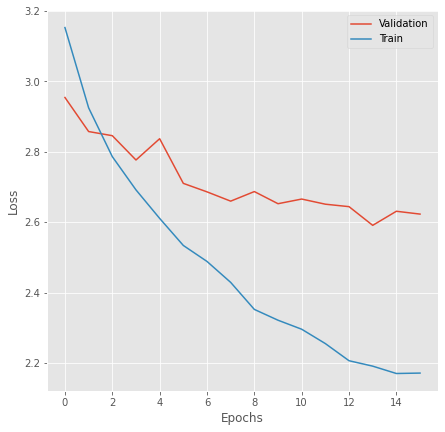

In [ ]:
trainer.push_to_hub("Training complete!")

df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()